# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 10

## Student 1 
### Name : Yuan Tian
### ID : 5816971

## Student 2
### Name : Raphael Frühwirth
### ID : 5897297

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

The datasets should be located in the same folder as this notebook file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor



from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


train_data_filename = "train_data.csv"
test_data_filename = "test_data.csv"
val_data_filename = "val_data.csv"

## 1. Familiarization task – 1 A4

In [2]:
def preprocess_data(data, test=False):
    # remove id and timestamp column
    if not test:
        data = data.drop(["Id", "Timestamp"], axis=1)
    else:
        data = data.drop(["Timestamp"], axis=1)
        
    # normalize data
    columns = data.columns
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=columns)

    return scaled_data    

def compute_performance_metrics(true_y, predict_y):
    f1 = f1_score(true_y, predict_y)
    recall = recall_score(true_y, predict_y)
    precision = precision_score(true_y, predict_y)

    return f1, recall, precision

def get_data(signal_exception=None):
    train_df = pd.read_csv(train_data_filename)
    test_df = pd.read_csv(test_data_filename)
    val_df = pd.read_csv(val_data_filename)
    
    train_data = preprocess_data(train_df)
    val_data = preprocess_data(val_df)
    test_data = preprocess_data(test_df, test=True)

    threshold = 0.9  
    correlation_matrix = train_data.corr()

    # calculate correlated pairs
    correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                if signal_exception in (correlation_matrix.columns[i], correlation_matrix.columns[j]):
                    continue
                correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
    
    unique_correlated_pairs = list(set(correlated_pairs))

    # drop highly correlated pairs
    columns_to_drop = set([x[0] for x in unique_correlated_pairs])
    train_data = train_data.drop(columns_to_drop, axis=1)
    val_data = val_data.drop(columns_to_drop, axis=1)
    test_data = test_data.drop(columns_to_drop, axis=1)

    return train_data, val_data, test_data


### 1a. Plot visualizations

In [3]:
train_df = pd.read_csv(train_data_filename)
test_df = pd.read_csv(test_data_filename)
val_df = pd.read_csv(val_data_filename)

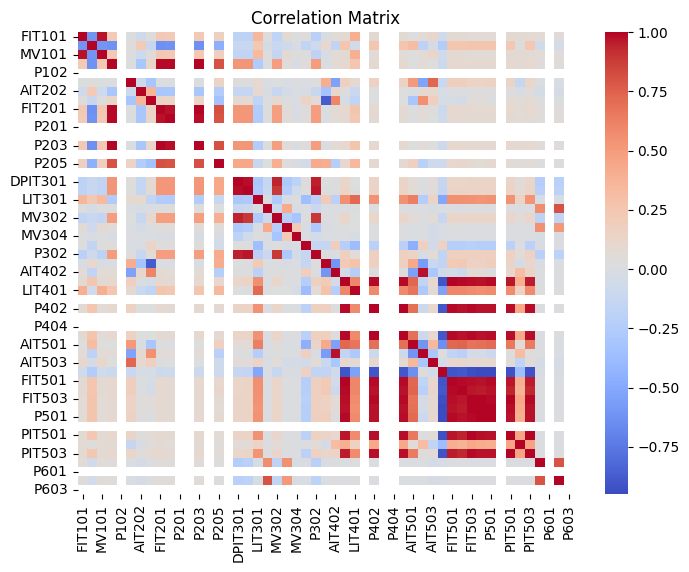

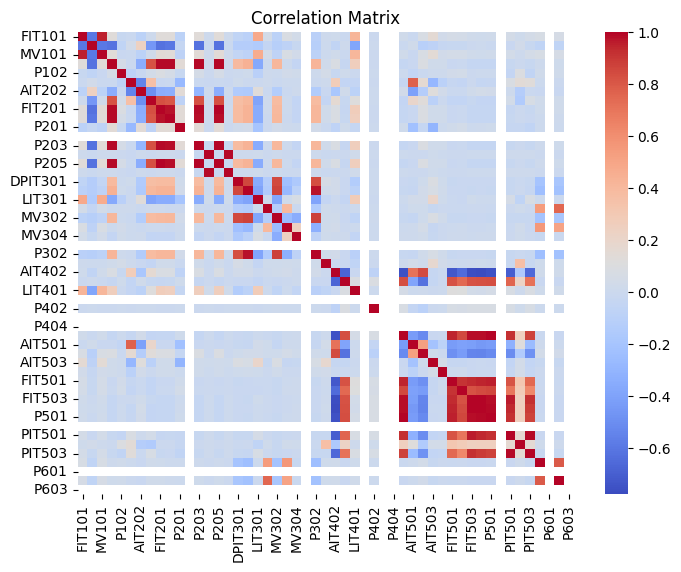

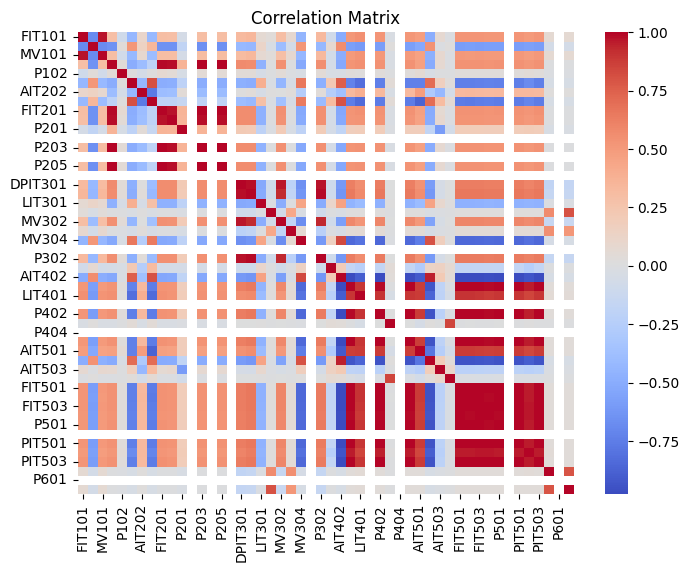

In [4]:
# visualize the data

for data in [train_df, val_df, test_df]:
    # Compute correlation matrix
    correlation_matrix = data.iloc[:, 2:-1].corr()

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


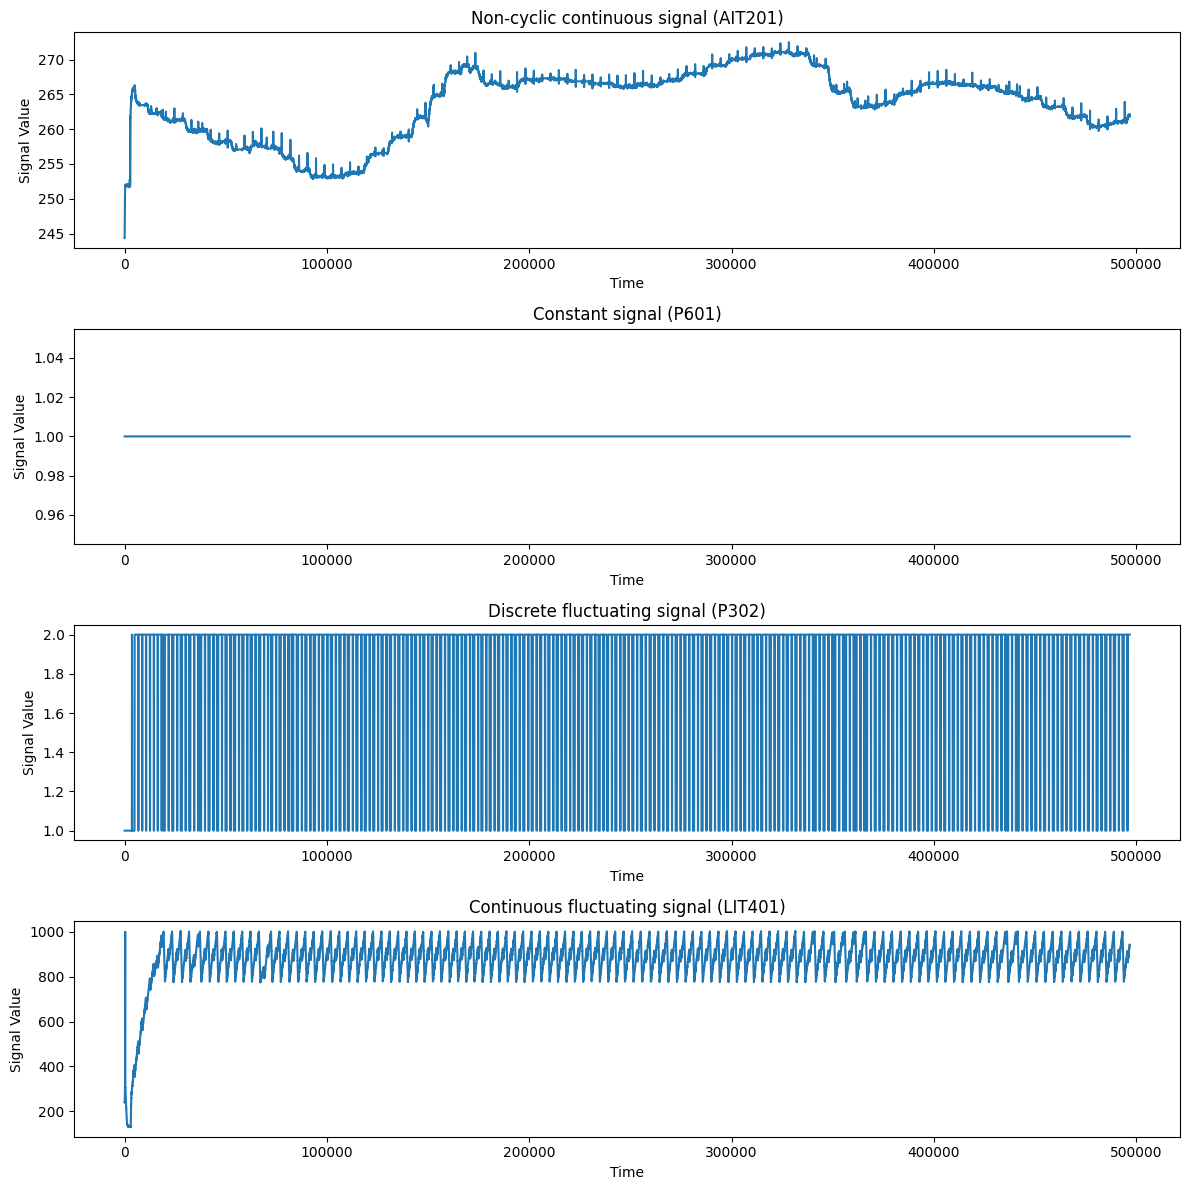

In [5]:
signals = {"AIT201":'Non-cyclic continuous signal', "P601":'Constant signal', "P302":'Discrete fluctuating signal', "LIT401":'Continuous fluctuating signal'}

# Plot 4 kinds of signal types
subset_signals = train_df[signals.keys()]
fig, axes = plt.subplots(len(subset_signals.columns), 1, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(subset_signals.columns):
    subset_signals[column].plot(ax=axes[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Signal Value')
    axes[i].set_title(f'{signals[column]} ({column})')

plt.tight_layout()
plt.show()


### 1b. Answers to the three questions

1. Signal Types:
- Discrete fluctuating signal: The signal fluctuates between two or three values with some variance. (ex: P302)
- Continuous fluctuating signal: The signal exhibits certain periodic behaviors that repeat over time. (ex: LIT401)
- Non-cyclic continous signal: The signal changes over time without a noticeable periodic pattern. (ex: AIT201)
- Constant signal: The signal remains steady(back up actuator). (ex: P601)

2. Signal correlation: From the correlation matrix, we can observe that there are many highly positively or negatively relations between the signals. For example when the P302 actuator activates the pump, the FIT302 sensor detects the increase in water flow thus FIT302 is highly correlated to P302. 

3. Cyclic behavior: The discrete fluctuating signal and constant signal exhibit cyclic behavior, as they repeat certain patterns over time. However, the non-periodic evolving signal does not demonstrate an obvious periodic pattern.



## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

In [6]:
clf = LocalOutlierFactor(n_neighbors=10, novelty=True)

sample_size = 25000 #len(train_df)

train_data, val_data, test_data = get_data()

# ignore first sample size because they are all anomalies
train_data = train_data[sample_size:sample_size*2].drop("Label", axis=1)
clf.fit(train_data)

LocalOutlierFactor(n_neighbors=10, novelty=True)

-0.8409549017204322 -215.04103794902835 941


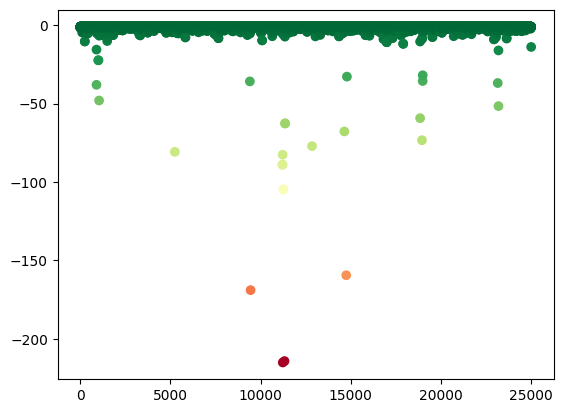

-0.8939556500082124 -87.52092874952564 834


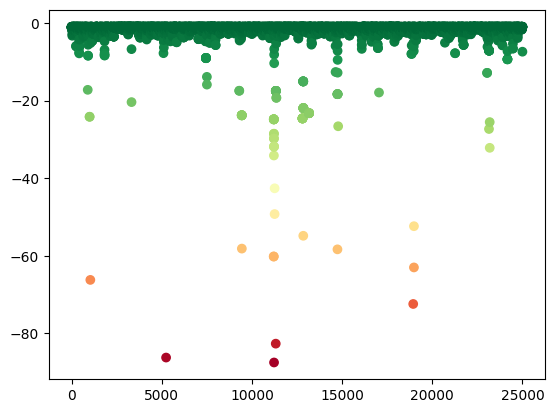

-0.8984744185117026 -55.82078787946008 633


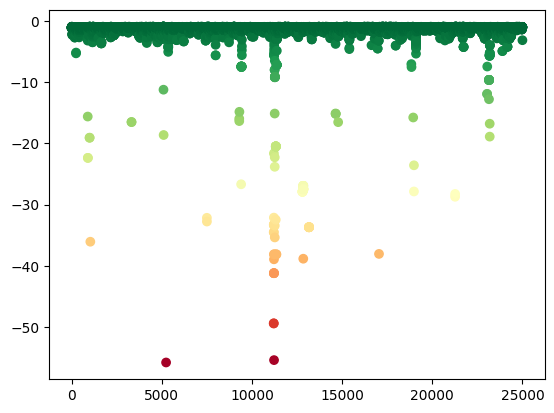

-0.9300292128844667 -38.68252232530507 544


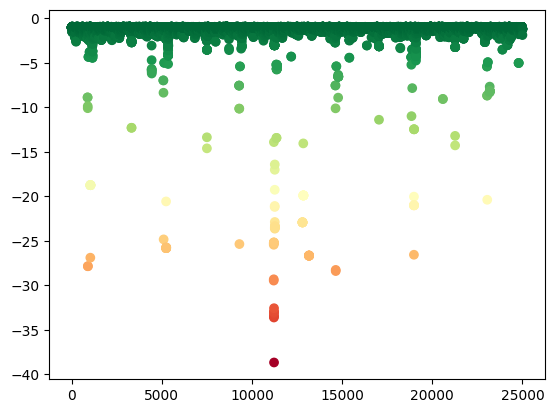

In [7]:
neighbors = [5, 10, 20, 40]
threshold = -2
for n in neighbors:
    clf = LocalOutlierFactor(n_neighbors=n, novelty=True)
    clf.fit(train_data)
    lof_scores = clf.negative_outlier_factor_
    print(lof_scores.max(), lof_scores.min(), len(np.where(lof_scores < -2)[0]))
    plt.scatter(range(len(lof_scores)), lof_scores, c=lof_scores, cmap='RdYlGn')
    plt.show()

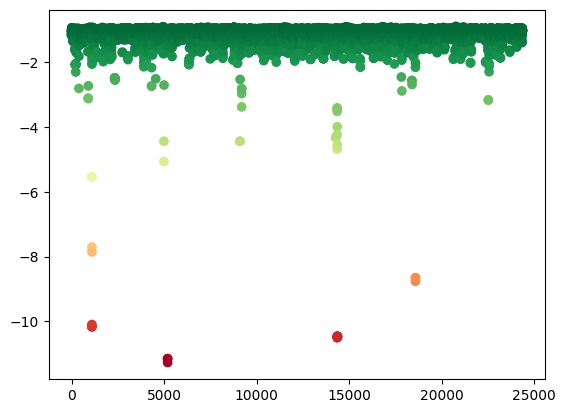

In [8]:
# train LOF with best number of neighbors based on the above plots
n = 20
clf = LocalOutlierFactor(n_neighbors=n, novelty=True)
clf.fit(train_data)

# identify and remove large abnormalities in training data
threshold = -2
lof_scores = clf.negative_outlier_factor_
train_data_removed = train_data.drop(np.where(lof_scores < threshold)[0]+sample_size)

# retrain on new training data
clf = LocalOutlierFactor(n_neighbors=n, novelty=True)
clf.fit(train_data_removed)
lof_scores = clf.negative_outlier_factor_

plt.scatter(range(len(lof_scores)), lof_scores, c=lof_scores, cmap='RdYlGn')

n=40 has the smallest amount of large abnormalities, however i think 20 is the best middleground based on the plot, because altough it shows more abnormalities there are not that many large ones. 
Additionally 20 is usually regarded as the best number of neighbors to use.

### 2b. Analysis and answers to the questions

In terms of LOF scores there are quite a few large abnormalities in my sample of the training data, with scores up to -200 for small n. When using a small number of neighbors in the LOF algorithm the amount of outliers detected increases drastically, for example n=5 detects 941 outliers while n=20 only classifies 633 datapoints as outliers. This is probably because with smaller number of neighbors more datapoints get classified as local outliers. 

These abnormalities could occur because in the beginning the whole system has to startup and for example the water tanks have to fill up that are detected by the inflow sensor (FIT-101), which could be classified as an abnormality. 

With LOF we can detect both local and global point anomalies and collective anomalies, however we can not detect contextual. 

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


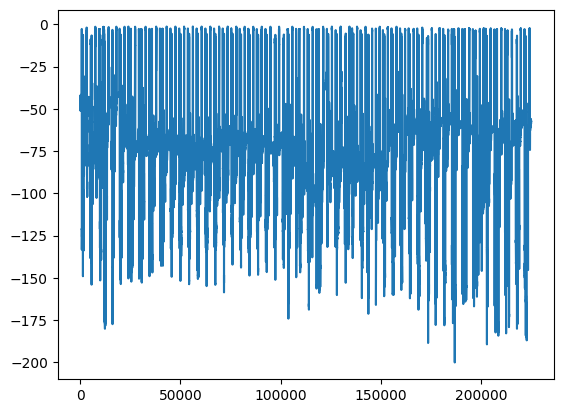

In [9]:
scores = clf.decision_function(val_data.drop("Label", axis=1))
plt.plot(range(len(scores)), scores)
signal_name = list(signals.keys())[3]

In [10]:
prediction_val_lof = clf.predict(val_data.drop("Label", axis=1))
prediction_val_lof = np.where(prediction_val_lof == 1, 0, np.where(prediction_val_lof == -1, 1, prediction_val_lof))
compute_performance_metrics(val_data['Label'], prediction_val_lof)

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


(0.09352740524163647, 1.0, 0.04905782831538191)

In [11]:
# predict test set for kaggle
y_pred = clf.predict(test_data.drop('Id', axis=1))
y_pred = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))
test_ids = pd.read_csv(test_data_filename)['Id']
results_lof = pd.DataFrame()
results_lof["ID"] = test_ids
results_lof["Label"] = y_pred
results_lof.to_csv("submission.csv", index=False)

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

the number of abnormalies when using 2 components is 33719
top 2 components can explain 0.645601760268896 of the variance
the number of abnormalies when using 3 components is 28727
top 3 components can explain 0.7755610287564823 of the variance
the number of abnormalies when using 4 components is 28830
top 4 components can explain 0.8329231023707819 of the variance
the number of abnormalies when using 5 components is 26428
top 5 components can explain 0.8748328838585258 of the variance
the number of abnormalies when using 6 components is 8511
top 6 components can explain 0.9006743028860921 of the variance
the number of abnormalies when using 7 components is 3198
top 7 components can explain 0.9211377633280367 of the variance
the number of abnormalies when using 8 components is 3221
top 8 components can explain 0.9364120948535116 of the variance


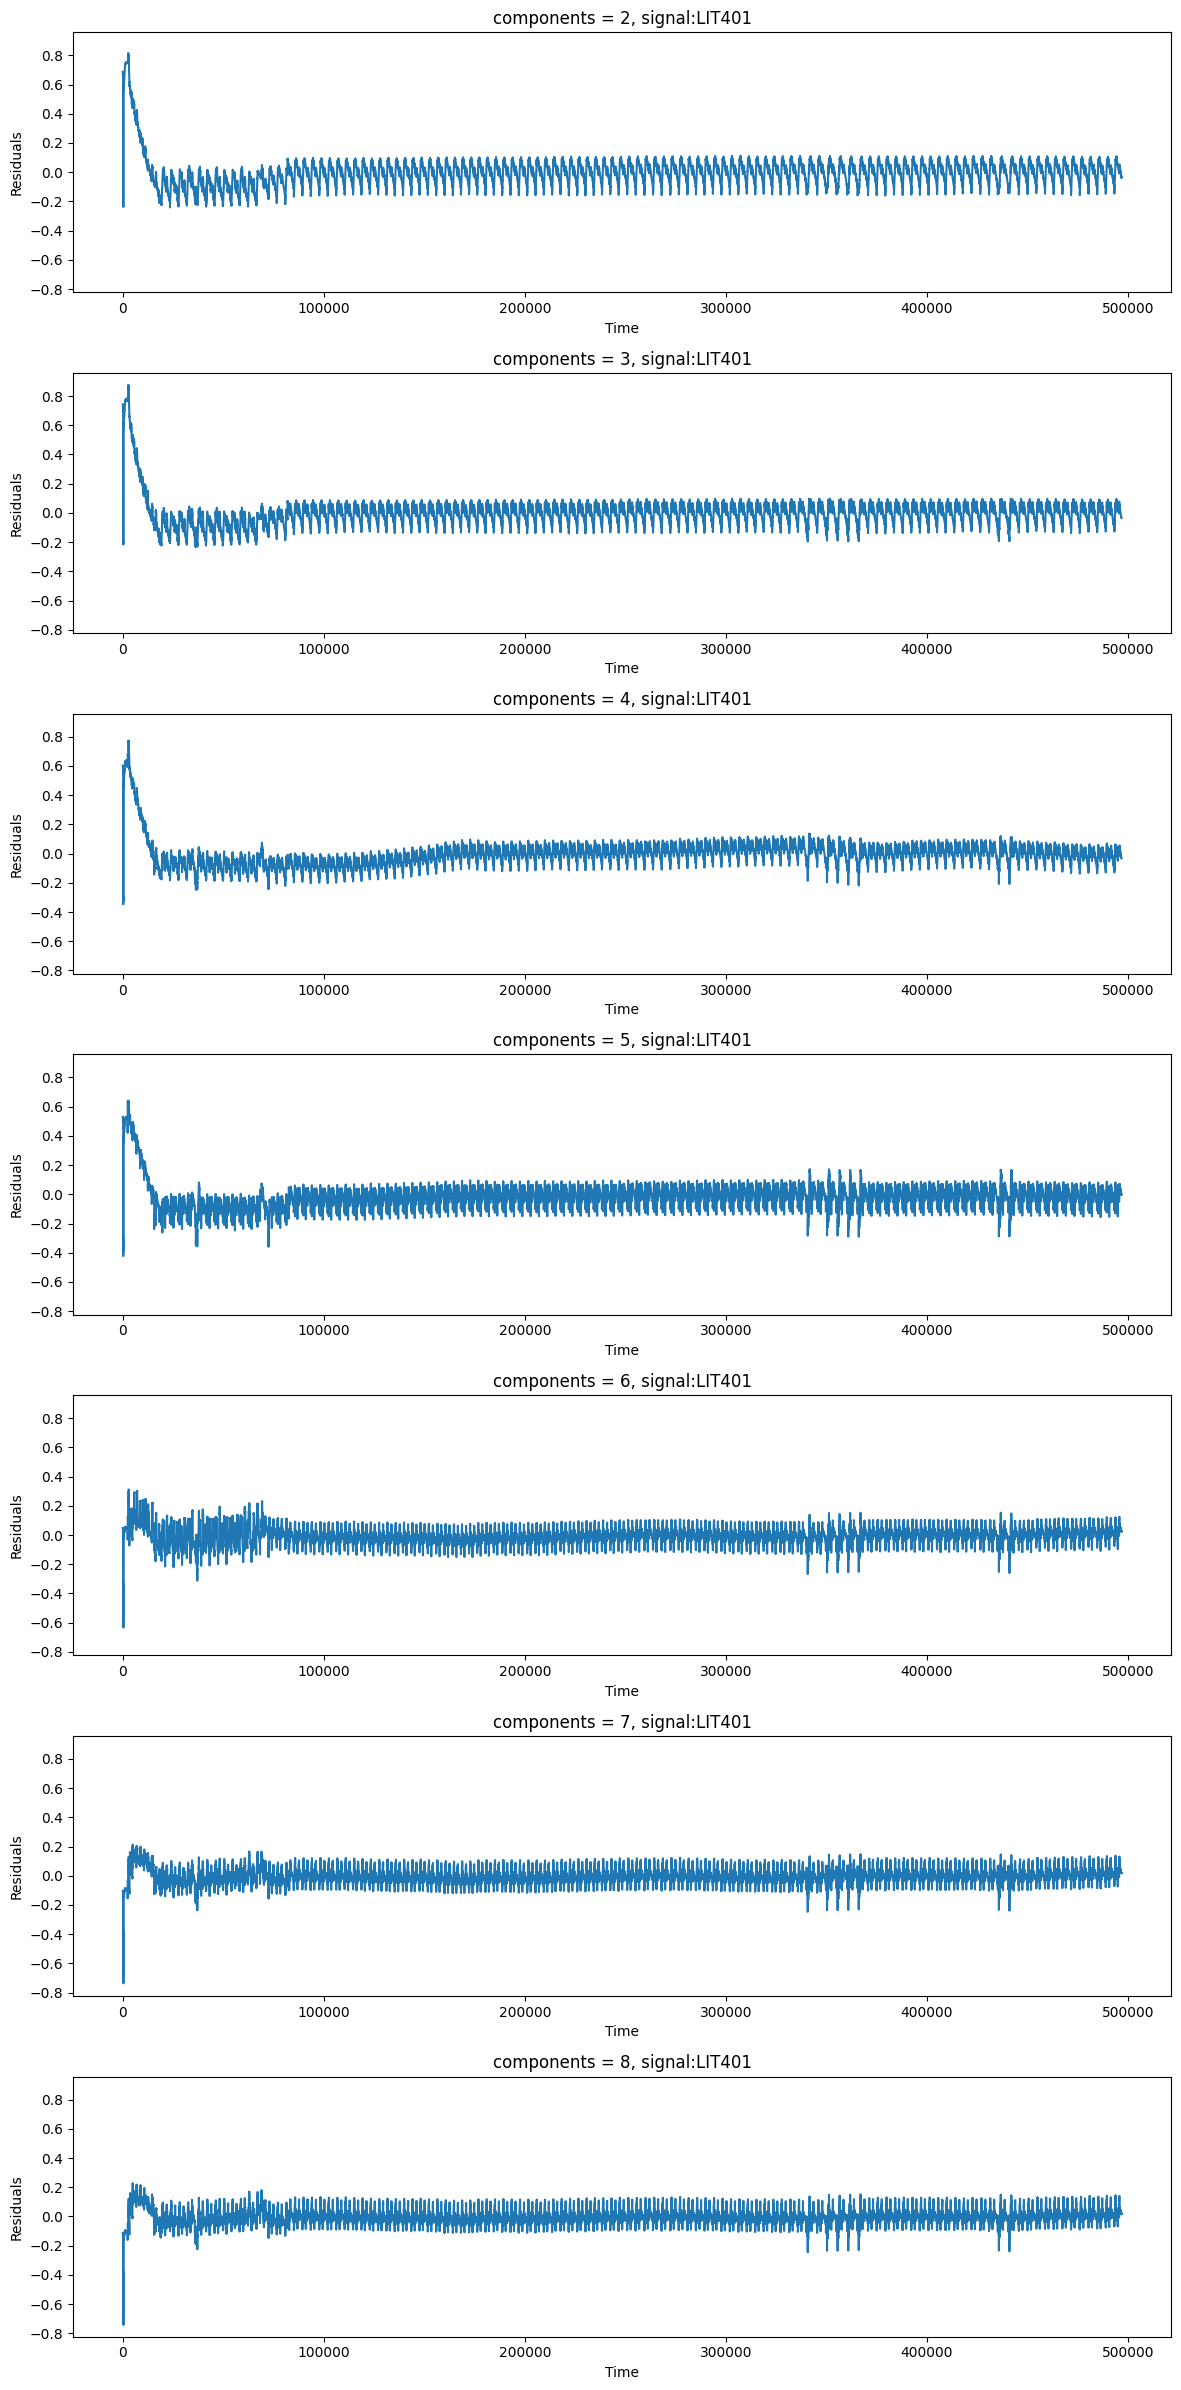

In [12]:
# select a signal and the threshold for resiudals
signal = signal_name
threshold_pca = 0.135


train_data, val_data, test_data = get_data()


# choose the best number of components
num_components = [2,3,4,5,6,7,8]

fig, axes = plt.subplots(len(num_components), 1, figsize=(12, 24), sharey=True)

for i, num in enumerate(num_components):
    pca = PCA(n_components=num, random_state=2)
    df_pca = pd.DataFrame(pca.fit_transform(train_data))
    df_restored = pd.DataFrame(pca.inverse_transform(df_pca), columns=train_data.columns)
    residuals = df_restored[signal] - train_data[signal]

    axes[i].plot(range(len(residuals)), residuals)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Residuals')
    axes[i].set_title("components = {}, signal:{}".format(num,signal))
    
    count = len(residuals[abs(residuals) >= threshold_pca])
    print("the number of abnormalies when using {} components is {}".format(num,count))
    print("top {} components can explain {} of the variance".format(len(pca.explained_variance_ratio_),sum(pca.explained_variance_ratio_)))

plt.tight_layout()
plt.show()

In [13]:
# Detect and remove anormalies for training data

num_components = 4
pca = PCA(n_components=num_components, random_state=2)
df_pca = pd.DataFrame(pca.fit_transform(train_data))
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), columns=train_data.columns)

residuals = df_restored[signal] - train_data[signal]

abnormal_index = residuals[abs(residuals) > threshold_pca].index

abnormal_removed = train_data.loc[~train_data.index.isin(abnormal_index)].drop("Label", axis=1)
print("Removed", len(abnormal_index), "training anomalies")

Removed 28830 training anomalies


In [14]:
# re-train the pca model
num = 4
pca = PCA(n_components=num, random_state=2)
df_pca = pd.DataFrame(pca.fit_transform(abnormal_removed), index=abnormal_removed.index)
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index, columns=abnormal_removed.columns)
print("top {} components can explain {} of the variance".format(len(pca.explained_variance_ratio_),sum(pca.explained_variance_ratio_)))

# read val data and normalize nad plot
labels = val_data['Label']
print("we have {} abnormalities in val dataset".format(len(labels[labels==1])))
val_data = val_data.drop("Label", axis=1)

# predict the validate data
df_pca = pd.DataFrame(pca.transform(val_data), index=val_data.index)
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index, columns=val_data.columns)
residuals = df_restored[signal] - val_data[signal]


prediction_val_pca = residuals.copy()
prediction_val_pca[abs(residuals) > threshold] = 1
prediction_val_pca[abs(residuals) <= threshold] = 0

best = 0
t = 0
for threshold in range(1, 21):
    threshold = threshold / 20.0 
    count = len(residuals[abs(residuals) > threshold])
    print("The number of predicted abnormalities when using {} as threshold is {}".format(threshold, count))

    # update residuals based on the threshold
    residuals_thresholded = residuals.copy()
    residuals_thresholded[abs(residuals_thresholded) > threshold] = 1
    residuals_thresholded[abs(residuals_thresholded) <= threshold] = 0

    # calculate the F1 score, precision, and recall
    f1 = f1_score(labels, residuals_thresholded)
    precision = precision_score(labels, residuals_thresholded)
    recall = recall_score(labels, residuals_thresholded)
    
    if precision > best:
        best = precision
        t = threshold
        
print("Best Threshold:", t)

top 4 components can explain 0.8588482867009957 of the variance
we have 11036 abnormalities in val dataset
The number of predicted abnormalities when using 0.05 as threshold is 190755
The number of predicted abnormalities when using 0.1 as threshold is 153667
The number of predicted abnormalities when using 0.15 as threshold is 118132
The number of predicted abnormalities when using 0.2 as threshold is 72872
The number of predicted abnormalities when using 0.25 as threshold is 36511
The number of predicted abnormalities when using 0.3 as threshold is 16330
The number of predicted abnormalities when using 0.35 as threshold is 12223
The number of predicted abnormalities when using 0.4 as threshold is 10894
The number of predicted abnormalities when using 0.45 as threshold is 9628
The number of predicted abnormalities when using 0.5 as threshold is 8285
The number of predicted abnormalities when using 0.55 as threshold is 6344
The number of predicted abnormalities when using 0.6 as thresh

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The number of predicted abnormalities when using 0.9 as threshold is 0


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The number of predicted abnormalities when using 0.95 as threshold is 0


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The number of predicted abnormalities when using 1.0 as threshold is 0
Best Threshold: 0.8


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


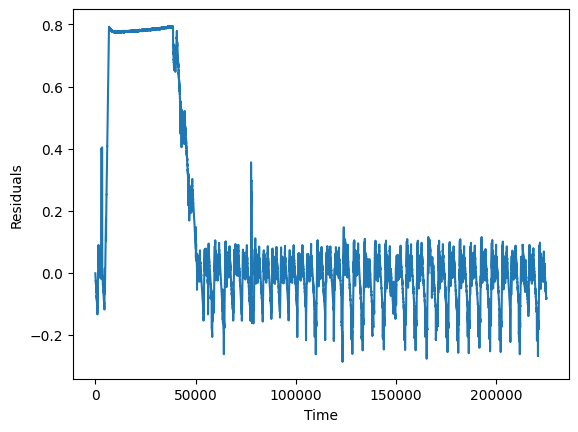

the number of abnormalies when using 4 components is 64030
count    224960.000000
mean          0.284628
std           0.451238
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: LIT401, dtype: float64


In [15]:
# PCA on test data
ids = pd.read_csv(test_data_filename)["Id"]
test_data = test_data.drop("Id", axis=1)
df_pca = pd.DataFrame(pca.transform(test_data))
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), columns=test_data.columns)

residuals = df_restored[signal] - test_data[signal]
plt.plot(range(len(residuals)), residuals.values)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

count = len(residuals[abs(residuals) > threshold_pca])
print("the number of abnormalies when using {} components is {}".format(num,count))


residuals[abs(residuals) > threshold_pca] = 1
residuals[abs(residuals) <= threshold_pca] = 0
print(residuals.describe())

results_pca = pd.DataFrame({'Id': ids, 'Label':residuals})
results_pca["Label"] = results_pca["Label"].astype(int)
results_pca.to_csv("result.csv", index = False)

### 3b. Analysis and answers to the questions

The number of anomalies generally decreases as the number of components increases, which is expected as using more principal components improves the reconstruction accuracy. However, for 3 and 4 components, the highest number of anomalies is detected. This can be explained by the fact that the first 3 and 4 components capture most of the data variance, and anomalies are more pronounced in these components. I chose 4 components as it detected more anomalies initially. Additionally, at the beginning of the time series, there are significant abnormalities, which can be attributed to the unstable state of the UF Feed Tank during the early stage of P3. PCA is effective in detecting collective anomalies as it considers the entire dataset and captures the patterns across all features.

## 4. ARMA task – 1/2 A4 - Individual

### 4a. Print relevant plots and/or metrics to determine the parameters.

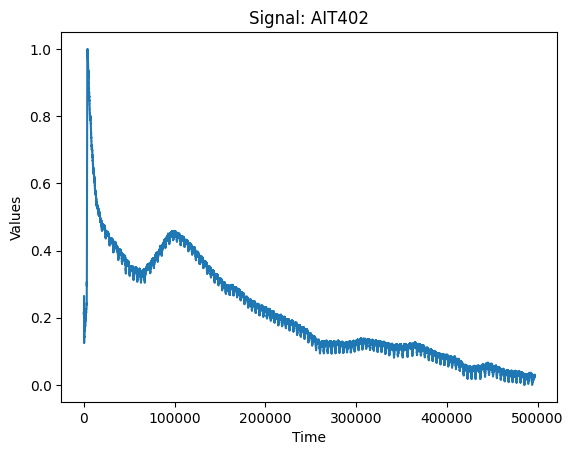

In [16]:
signal = "AIT402"

train_data, val_data, test_data = get_data(signal_exception=signal)


series = train_data[signal]
plt.plot(range(len(series)), series.values)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title("Signal: {}".format(signal))
plt.show()

In [17]:
slice_index = 25000

def test_stationarity(ts_data, signif=0.05):
    adf_test = adfuller(ts_data.loc[:slice_index], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        print("Stationary")
    else:
        print("Non-Stationary")
test_stationarity(series)

def differencing(data, order):
    differenced_data = data.diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
print("After differencing: ")
differenced_series = differencing(series, 1)
test_stationarity(differenced_series)

Non-Stationary
After differencing: 
Stationary


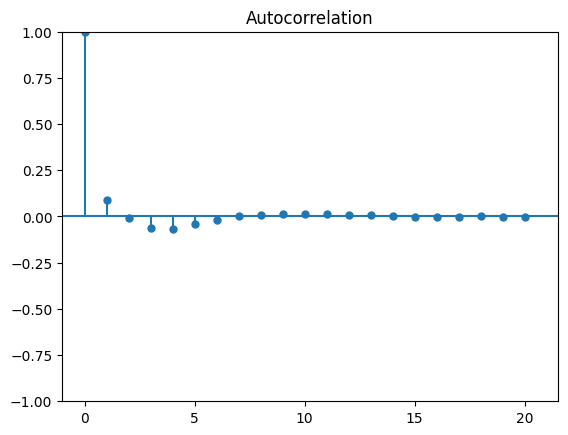

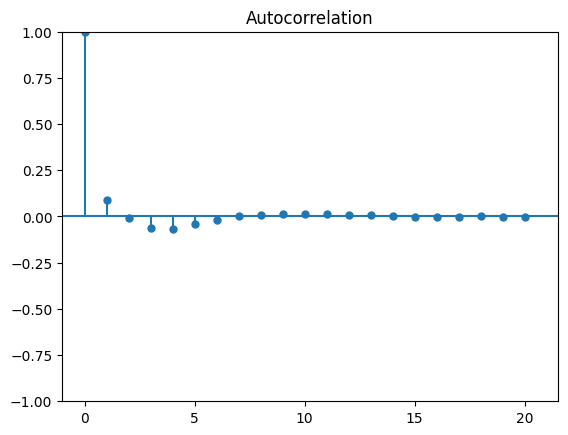

In [18]:
plot_acf(differenced_series, lags = 20) 

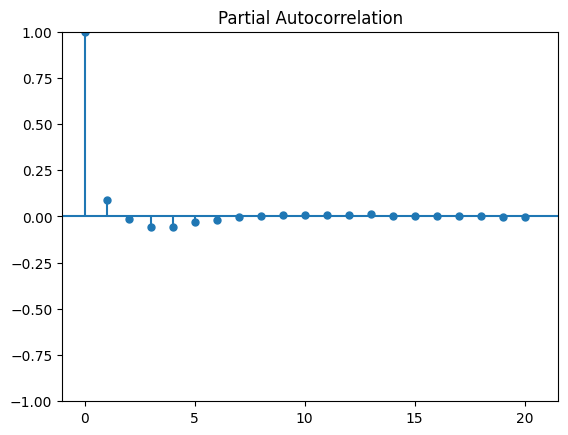

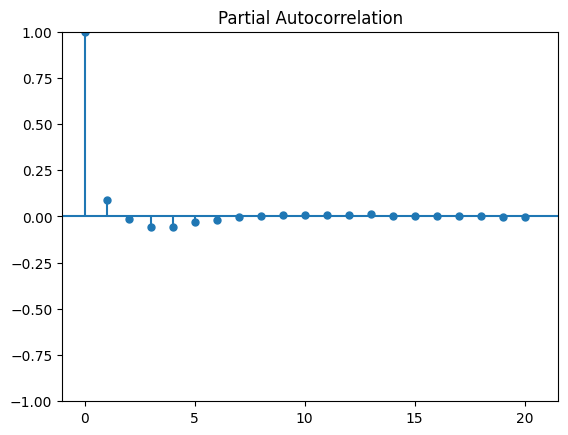

In [19]:
plot_pacf(differenced_series, lags=20)

In [20]:
# without differencing
# Load the time series data

# Calculate the index for splitting the data
split_index = int(len(train_df) * 0.08)

train_data_raw, val_data_raw, test_data_raw = get_data(signal_exception=signal)

# Split the data into training and testing sets
train_data = train_data_raw.iloc[:split_index][signal]
test_data = train_data_raw.iloc[split_index:len(train_data_raw)][signal]

# Reset the index of the training and testing data in case of warning
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Define the parameter grid
p_values = range(1, 3)
q_values = range(1, 3)

# Initialize variables to store best parameters and best MSE
best_mse = np.inf
best_params = None

# Perform grid search
for p in p_values:
    for q in q_values:
            # Fit the ARMA model on the training data
            model = ARIMA(train_data, order=(p, 0, q)).fit()

            # Make predictions on the testing data
            predictions = model.predict(start=len(train_data), end= len(train_data) + len(test_data) - 1)

            # Evaluate the model using MSE
            mse = mean_squared_error(test_data, predictions)

            # Check if this is the best model so far
            if mse < best_mse:
                best_mse = mse
                best_params = (p, q)

# Print the best parameters
print("Best parameters (p, q) without differencing:", best_params)
print("Best MSE without differencing:", best_mse)

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best parameters (p, q) without differencing: (1, 1)
Best MSE without differencing: 0.1144814132952939


In [21]:
# with differencing

split_index = int(len(train_df) * 0.08)

# Split the data into training and testing sets
train_data = differenced_series.iloc[:split_index]
test_data = differenced_series.iloc[split_index:len(train_data_raw)]

# Reset the index of the training and testing data in case of warning
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Perform grid search
for p in p_values:
    for q in q_values:
            # Fit the ARMA model on the training data
            model = ARIMA(train_data, order=(p, 0, q)).fit()

            # Make predictions on the testing data
            predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

            # Evaluate the model using MSE
            mse = mean_squared_error(test_data, predictions)

            # Check if this is the best model so far
            if mse < best_mse:
                best_mse = mse
                best_params = (p, q)

# Print the best parameters
print("Best parameters (p, q) with differencing:", best_params)
print("Best MSE withdifferencing:", best_mse)

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best parameters (p, q) with differencing: (2, 1)
Best MSE withdifferencing: 2.853963967928481e-07


### 4b. Plots to study the detected anomalies

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 AIT402   No. Observations:               124200
Model:                 ARIMA(1, 0, 2)   Log Likelihood              755487.436
Date:                Tue, 06 Jun 2023   AIC                       -1510964.871
Time:                        02:01:26   BIC                       -1510916.223
Sample:                             0   HQIC                      -1510950.250
                             - 124200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.461e-06    1.8e-06      0.810      0.418   -2.07e-06       5e-06
ar.L1         -0.1932      0.001   -173.428      0.000      -0.195      -0.191
ma.L1          0.3083      0.001    288.040      0.0

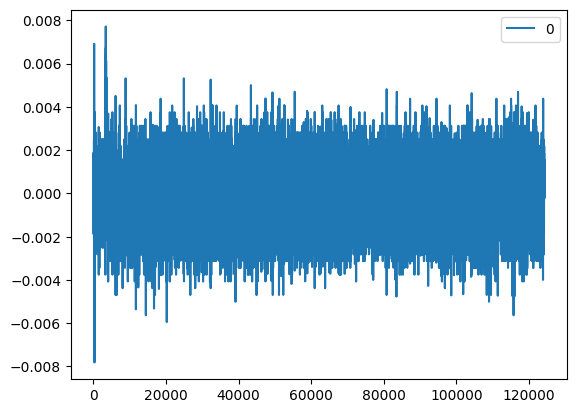

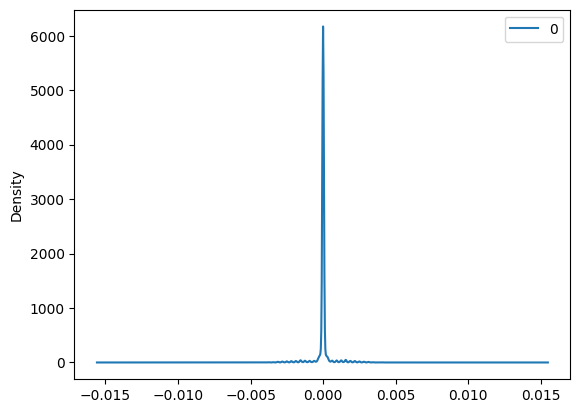

                  0
count  1.242000e+05
mean  -9.046301e-13
std    5.521095e-04
min   -7.814630e-03
25%   -1.278757e-06
50%   -1.272094e-06
75%   -1.266233e-06
max    7.716257e-03


In [22]:
subset_index = len(train_df)//4
model_fit = ARIMA(differenced_series[:subset_index], order=(1, 0, 2)).fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

0.0045901926270252545


Text(0, 0.5, 'Residuals')

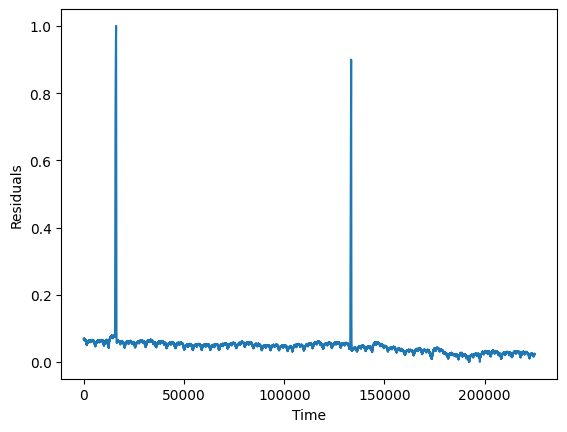

In [23]:
train_data, val_data, test_data = get_data(signal_exception=signal)

real = val_data[signal]

# Make predictions on the validation data
predictions = model_fit.predict(start=0, end=len(val_data)-1)

# Evaluate the model using MSE
mse = mean_squared_error(real, predictions)
print(mse)

residuals = real - predictions

plt.plot(range(len(residuals)), residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')

In [24]:
threshold = 0.06
count = len(residuals[abs(residuals) > threshold])
labels = val_data['Label']

print("the number of predicted abnormalies is {}".format(count))
print("the number of actual abnormalies is {}".format(len(labels[labels==1])))

residuals[abs(residuals) > threshold ] = 1
residuals[abs(residuals) <= threshold ] = 0

prediction_val_arma = residuals

# Calculate the F1 score. precision and recall 
f1 = f1_score(labels, residuals)
precision = precision_score(labels, residuals)
recall = recall_score(labels, residuals)
print(f'With differencing applied:\n\nF1 | Recall | Precision: \n{compute_performance_metrics(labels, residuals)}')

the number of predicted abnormalies is 20587
the number of actual abnormalies is 11036
With differencing applied:

F1 | Recall | Precision: 
(0.21832210732694557, 0.31279449075752086, 0.16767863214650022)


0.1261977505875373
the number of predicted abnormalies is 41809


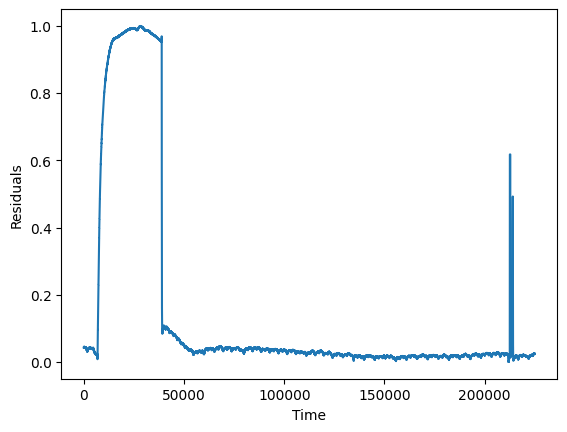

In [25]:
real = test_data[signal]
ids = pd.read_csv(test_data_filename)["Id"]
# Make predictions on the validation data
predictions = model_fit.predict(start=0, end=len(test_data)-1)

# Evaluate the model using MSE
mse = mean_squared_error(real, predictions)
print(mse)

residuals = real-predictions

plt.plot(range(len(residuals)), residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
count = len(residuals[abs(residuals) > threshold])
print("the number of predicted abnormalies is {}".format(count))


residuals[abs(residuals) > threshold] = 1
residuals[abs(residuals) <= threshold] = 0

In [26]:
results_arma = pd.DataFrame({'Id': ids, 'Label':residuals})
results_arma['Label'] = results_arma['Label'].astype(int)
results_arma['Id'] = results_arma['Id'].astype(int)
results_arma.to_csv("result.csv", index = False)

### 4c. Analysis and answers to the questions

As shown in the partial autocorrelation plots, there is high degree of autocorrelation between lag = 1 in PACF plot, so  we can use an AR(1) model to model this process. And same for the autocorrelation plot, there is high degree of autocorrelation between lag = 1 in ACF plot, so we choose MA(1).  However, the grid search yielded different optimal parameters (p=2, q=1) compared to the plots,which might be explained by the fact that the ACF and PACF plots provide insights into the correlation structure of the time series while grid search often optimizes a specific criterion such as AIC. But the final results obtained from the two combinations of parameters are close, indicating that the difference between the parameters is negligible. And the mse is significantly smaller with differencing applied than not, which shows that the predictive performance increases.

The linear regressor is effective in detecting point and collective anomalies. It compares predicted values with real values for each data point, making it suitable for identifying individual anomalies. Additionally, it can capture anomalies that occur collectively.

3 different sensors were tested separately. The linear regressor model overfits when applied to signal LIT301 (Continuous fluctuating signal), as indicated by all residuals being 0. Despite a high recall, the precision and F1 score are close to 0, suggesting a high number of false positives. In the case of signal P302 (Discrete fluctuating signal), the residuals exhibit a similar pattern to the signal itself, indicating that the linear regressor struggles to capture its pattern effectively. Conversely, for AIT402 (Non-cyclic continuous signal), the linear regressor performs well. Thus, the linear regressor is more suitable for sensors that do not exhibit a consistent pattern over time.

## 5. N-gram task – 1/2 A4 - Individual

### 5a. Visualise discretization

Text(0.5, 1.0, 'Discretized Signal (AIT201)')

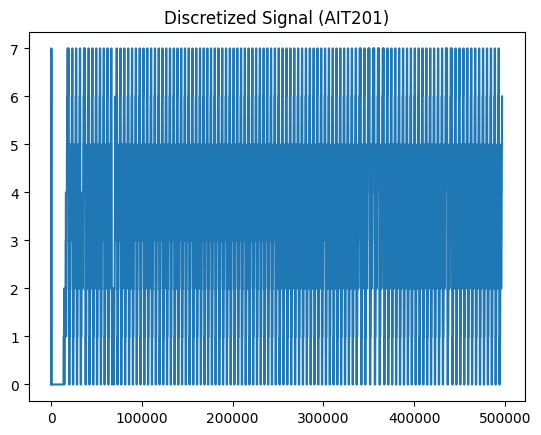

In [27]:
train_data, val_data, test_data = get_data()
signal = train_data[signal_name]
discrete_data, bins = pd.qcut(signal, q=8, labels=False, retbins=True)

plt.plot(discrete_data)
plt.title("Discretized Signal (AIT201)")


### 5b. Analysis and answers to the questions. Also provide relevant plots.

In [28]:
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors

def create_ngram_table(data, discretize, window_size=32, q=8):
    if discretize:
        data, bins = pd.qcut(data, q, labels=False, retbins=True)
        
    windows = (data[i:i+window_size] for i in range(len(data)-window_size))
    ngram_size = 3
    window_size = 32

    windows = (data[i:i+window_size] for i in range(len(data)-window_size))

    unique_ngrams = set()
    for window in windows:
        window = list(window)
        ngrams = [window[i:i+ngram_size] for i in range(len(window)-ngram_size)]    
        for ngram in ngrams:
            ngram = str(ngram)
            unique_ngrams.add(ngram)

    windows = (data[i:i+window_size] for i in range(len(data)-window_size))

    table = []
    for window in windows:
        ngram_dict = defaultdict(int, {k:0 for k in unique_ngrams})
        window = list(window)
        ngrams = [window[i:i+ngram_size] for i in range(len(window)-ngram_size)]
        for ngram in ngrams:
            ngram = str(ngram)
            ngram_dict[ngram] += 1
        table.append(ngram_dict.values())

    table = pd.DataFrame(table, columns=list(unique_ngrams))    

    return table

def get_ngram_tables(signal, val_signal, discretize_flag=True):
    # create ngram tables
    ngram_table = create_ngram_table(signal, discretize_flag)
    val_ngram_table = create_ngram_table(val_signal, discretize_flag)

    # fix missing ngram columns
    columns_union = ngram_table.columns.union(val_ngram_table.columns)
    ngram_table = ngram_table.reindex(columns=ngram_table.columns.union(columns_union))
    val_ngram_table = val_ngram_table.reindex(columns=val_ngram_table.columns.union(columns_union))

    ngram_table.fillna(0, inplace=True)
    val_ngram_table.fillna(0, inplace=True)

    # reorder columns
    ngram_table = ngram_table[val_ngram_table.columns]

    return ngram_table, val_ngram_table


In [29]:
# define signals
signal = train_data[signal_name][sample_size:sample_size*2]
val_signal = val_data[signal_name]
ngram_table, val_ngram_table = get_ngram_tables(signal, val_signal)

In [30]:
# train NN on training table
knn = NearestNeighbors(n_neighbors=10, metric='cosine').fit(ngram_table)
distances, indices = knn.kneighbors(ngram_table)
average_distances = distances.mean(axis=1)

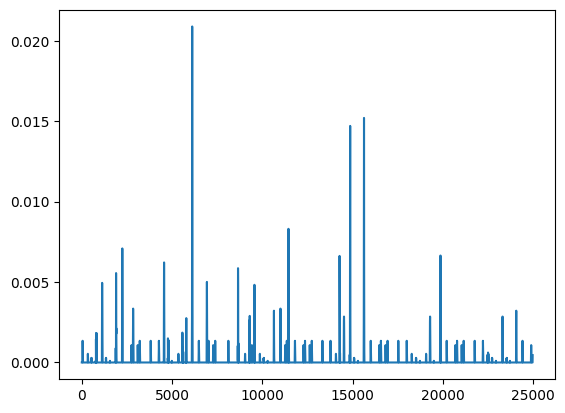

In [31]:
# compute anomalies and plot residuals
threshold = 0.001
anomalies = [i for i, d in enumerate(average_distances) if d > threshold]
plt.plot(range(len(average_distances)), average_distances)

In [32]:
# find anomalies in validation ngram table
distances, indices = knn.kneighbors(val_ngram_table)
avgs = distances.mean(axis=1)
val_anomalies = [i for i, d in enumerate(avgs) if d > threshold]
print(f"Found {len(val_anomalies)} anomalies in validation data")

Found 9310 anomalies in validation data


In [33]:
# compute performance metrics
val_y = val_data['Label']
pred_y = np.zeros(len(val_y))
pred_y[val_anomalies] = 1

prediction_val_ngram = pred_y

compute_performance_metrics(val_y, pred_y)


(0.04541433205544087, 0.041862993838347226, 0.04962406015037594)

In [34]:
### Do the same thing for differenced data ###
# difference signalss)
differenced = pd.qcut(signal, 8, labels=False, retbins=True)[0].diff().dropna()
differenced_val = pd.qcut(val_signal, 8, labels=False, retbins=True)[0].diff().dropna()
differenced_ngram_table, differenced_ngram_table_val = get_ngram_tables(differenced, differenced_val, False)

In [35]:
# train NN on training table
knn_diff = NearestNeighbors(n_neighbors=10, metric='cosine').fit(differenced_ngram_table)
distances_diff, indices = knn_diff.kneighbors(differenced_ngram_table)
average_distances_diff = distances_diff.mean(axis=1)

In [36]:
# find anomalies in validation ngram table
distances_val_diff, indices = knn_diff.kneighbors(differenced_ngram_table_val)
average_distances_diff_val = distances_val_diff.mean(axis=1)
val_anomalies_diff = [i for i, d in enumerate(average_distances_diff_val) if d > 0]
print(f"Found {len(val_anomalies_diff)} anomalies in validation data")

Found 5664 anomalies in validation data


In [37]:
# compute performance metrics
val_y = val_data['Label']
pred_y_dif = np.zeros(len(val_y))
pred_y_dif[val_anomalies_diff] = 1

compute_performance_metrics(val_y, pred_y_dif)


(0.04275449101796408, 0.032348677056904675, 0.06302966101694915)

In [38]:
print(f'F1 | Recall | Precision: \n{compute_performance_metrics(val_y, pred_y)}\n')
print(f'With differencing applied:\n\nF1 | Recall | Precision: \n{compute_performance_metrics(val_y, pred_y_dif)}')

F1 | Recall | Precision: 
(0.04541433205544087, 0.041862993838347226, 0.04962406015037594)

With differencing applied:

F1 | Recall | Precision: 
(0.04275449101796408, 0.032348677056904675, 0.06302966101694915)


Applying differencing to the timeseries in general does not seem to improve the performance of the anomaly detection. However while both the f1-score and the recall decrease the precision gets better after applying differencing. In general I would not advice using differenced data with ngrams, except if precision is really important for the problem.

The ngram approach is able to detect contextual anomalies based on the window and ngram sizes, however with this approach it is not possible to detect collective anomalies.

This approach works best for continuous(LIT401) and non-cyclic(AIT201) signals and does not really make sense for fluctuating signals like P302.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

We decided to use point-wise methods because the main advantage of point-wise methods is their ability to detect anomalies by analyzing individual data points independently, regardless of the underlying time series structure. This allows for simpler analysis and decision-making. As we should be more cautious with false positives as they would lead to unnecessary costs, we prioritize higher precision in our results. The results are as follows. 
Among the different models evaluated, ARMA demonstrates significantly higher precision compared to the others. It also achieves the highest F1 score, indicating a balance between precision and recall. Additionally, ARMA exhibits simplicity, low computational cost, and ease of interpreting the results, which are beneficial qualities, particularly for large datasets.

| Method | Precision | Recall | F1 Score |
|--------|----------|--------|----------|
| ARMA   | 0.1676   | 0.3132 | 0.2182   |
| LOF    | 0.0935   | 0.0418 | 0.0491   |
| PCA    | 0.0531   | 0.8865  | 0.1002  |
| NGRAM  | 0.0454   | 0.0419 | 0.0496   |

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

We thought of combining all the models into basically one ensemble that performs majority voting on the predicted labels. We predict the anomalies with all 4 models and if two or more of them classify them as anomalies we consider them as such otherwise we regard them as regular data points

In [39]:
all_model_predictions = np.stack((prediction_val_arma, prediction_val_lof, prediction_val_ngram, prediction_val_pca))
votes = np.sum(all_model_predictions, axis=0)
combined_predictions = np.where(votes >= 3, 1, 0)
print(f'F1 | Recall | Precision: \n{compute_performance_metrics(val_data["Label"], combined_predictions)}\n')

F1 | Recall | Precision: 
(0.18745162659476192, 0.3401594780717651, 0.12937243684736532)



Combining all predictions of our models overall seems to work quite well. It achieves better precision as all the other model.
Regarding Recall and F1 scores the combined method works averagely well. 


| Method | Precision | Recall | F1 Score |
|--------|----------|--------|----------|
| ARMA   | 0.1676   | 0.3132 | 0.2182   |
| LOF    | 0.0935   | 0.0418 | 0.0491   |
| PCA    | 0.0531   | 0.8865  | 0.1002  |
| NGRAM  | 0.0454   | 0.0419 | 0.0496   |
| Combined | 0.2007 | 0.3039 | 0.1498 |
